# Supplemental Information:

> **"Clonal heterogeneity influences the fate of new adaptive mutations"**

> Ignacio Vázquez-García, Francisco Salinas, Jing Li, Andrej Fischer, Benjamin Barré, Johan Hallin, Anders Bergström, Elisa Alonso-Pérez, Jonas Warringer, Ville Mustonen, Gianni Liti

## Figure 3 (+ Supp. Figs.)

This IPython notebook is provided for reproduction of Figures 2, S3, S4 and S7 of the paper. It can be viewed by copying its URL to nbviewer and it can be run by opening it in binder.

In [19]:
# Load external dependencies
from setup import *
# Load internal dependencies
import config,gmm,plot,utils

%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
ids = pd.read_csv(dir_data+'seq/sample_ids_merged_dup.csv')

ids.loc[ids.clone.isnull(),'type'] = 'population'
ids.loc[(ids.clone.notnull()) & (ids.time==0),'type'] = 'ancestral clone'
ids.loc[(ids.clone.notnull()) & (ids.time==32),'type'] = 'evolved clone'

for seq_type, seq_id in ids.groupby('type'):
    print('{0} sequencing coverage\nBottom quartile: {1:.2f}x, Top quartile: {2:.2f}x, Min: {3:.2f}x, Max: {4:.2f}x, Median: {5:.2f}x\n'\
    .format(seq_type.capitalize(),
            seq_id['coverage'].quantile(.25), \
            seq_id['coverage'].quantile(.75), \
            seq_id['coverage'].min(), \
            seq_id['coverage'].max(), \
            seq_id['coverage'].median()))

Ancestral clone sequencing coverage
Bottom quartile: 15.45x, Top quartile: 26.13x, Min: 9.06x, Max: 36.60x, Median: 23.37x

Evolved clone sequencing coverage
Bottom quartile: 28.48x, Top quartile: 31.96x, Min: 26.06x, Max: 36.01x, Median: 30.38x

Population sequencing coverage
Bottom quartile: 84.10x, Top quartile: 103.98x, Min: 24.66x, Max: 150.10x, Median: 94.81x



## Data import

Top panels - Import subclonal frequency

In [21]:
# Load data
seq_st_df = pd.read_csv(dir_data+'seq/subclonality/seq_subclonality.csv', encoding='utf-8')

# Compute cumulative haplotype frequencies for major subclones
seq_st_df['clonal'] = seq_st_df.apply(
    lambda x: 
    x[['subclone A','subclone B','subclone C','subclone D']].fillna(0).sum(), 
    axis=1
)
# Calculate the remaining bulk fraction
seq_st_df['bulk'] = 1.0 - seq_st_df['clonal']

seq_st_df.head()

,background,cross,cross_rep,selection,selection_rep,subclone A,subclone B,subclone C,subclone D,time,population,sample,clonal,bulk
0,WAxNA,F12,2,RM,2,0.0200,NaN,NaN,NaN,2,WAxNA_F12_2_RM_2,WAxNA_F12_2_RM_2_T2,0.0200,0.9800
1,WAxNA,F12,2,RM,2,0.0202,NaN,NaN,NaN,4,WAxNA_F12_2_RM_2,WAxNA_F12_2_RM_2_T4,0.0202,0.9798
2,WAxNA,F12,2,RM,2,0.0705,NaN,NaN,NaN,8,WAxNA_F12_2_RM_2,WAxNA_F12_2_RM_2_T8,0.0705,0.9295
3,WAxNA,F12,2,RM,2,0.1098,NaN,NaN,NaN,16,WAxNA_F12_2_RM_2,WAxNA_F12_2_RM_2_T16,0.1098,0.8902
4,WAxNA,F12,2,RM,2,0.1097,NaN,NaN,NaN,32,WAxNA_F12_2_RM_2,WAxNA_F12_2_RM_2_T32,0.1097,0.8903


Middle panels - Import mutation counts

In [22]:
# Load data
seq_dn_df = pd.read_csv(dir_data+'seq/de-novo/seq_de_novo_snv_indel.csv', encoding='utf-8', keep_default_na=False)

print(seq_dn_df.shape)
seq_dn_df.head()

(572, 83)


,ac,af,alt,an,allele,amino_acids,biotype,baseqranksum,cds_position,chr_arabic,...,population,coverage,substitution,assignment,mutation_type,chr_length,chr_roman,pos_cum,variant_type,consequence_short
0,1,0.1,[A],2.0,,,non-coding,1.093,,7,...,NA_HU_1,57.370612,G>A,bulk,passenger,1090940,VII,4141136.0,snv,non-coding
1,0,0.1,[A],2.0,A,K/M,protein_coding,-0.027,341,7,...,NA_HU_1,57.370612,T>A,bulk,driver,1090940,VII,4594951.0,snv,non-synonymous
2,0,0.1,[A],2.0,A,R/I,protein_coding,-1.198,101,7,...,NA_HU_1,57.370612,C>A,bulk,driver,1090940,VII,4595191.0,snv,non-synonymous
3,1,0.1,[T],2.0,,,non-coding,0.395,,12,...,NA_HU_1,57.370612,C>T,bulk,passenger,1078177,XII,8063245.0,snv,non-coding
4,1,0.1,[A],2.0,A,G,protein_coding,0.956,861,14,...,NA_HU_1,57.370612,C>A,bulk,passenger,784333,XIV,9384437.0,snv,synonymous


The tally of SNVs and indels across whole-population genome sequences is:

In [23]:
seq_dn_df[(seq_dn_df.clone!='')].groupby(['selection','population','time','variant_type']).size()

selection  population        time  variant_type
HU         WAxNA_F12_1_HU_1  32    snv             11
           WAxNA_F12_1_HU_2  32    snv             10
           WAxNA_F12_1_HU_3  32    snv             17
           WAxNA_F12_2_HU_1  32    snv              8
           WAxNA_F12_2_HU_2  32    snv             17
           WAxNA_F12_2_HU_3  32    indel            1
                                   snv             19
RM         WAxNA_F12_1_RM_1  32    indel            1
                                   snv             10
           WAxNA_F12_1_RM_2  32    snv             14
           WAxNA_F12_1_RM_3  32    snv             15
           WAxNA_F12_2_RM_1  32    snv              9
           WAxNA_F12_2_RM_2  32    snv              6
           WAxNA_F12_2_RM_3  32    snv              2
YPD        WAxNA_F12_1_YPD   0     indel            2
                                   snv             38
           WAxNA_F12_2_YPD   0     indel            7
                                  

In [24]:
seq_dn_df[(seq_dn_df.time==0) & (seq_dn_df.clone!='') & (seq_dn_df.ploidy=='haploid')].groupby(['selection','mutation_type','variant_type']).size()

selection  mutation_type  variant_type
YPD        passenger      indel            9
                          snv             82
dtype: int64

In [25]:
seq_dn_df[(seq_dn_df.time==32) & (seq_dn_df.clone!='')].groupby(['selection','mutation_type','variant_type']).size()

selection  mutation_type  variant_type
HU         driver         snv             22
           passenger      indel            1
                          snv             60
RM         driver         snv             13
           passenger      indel            1
                          snv             43
dtype: int64

Bottom panels - Import phenotype evolution

In [26]:
# Load data
pheno_df = pd.read_csv(dir_data+'pheno/populations/pheno_populations.csv.gz', encoding='utf-8', keep_default_na=False, na_values='NaN')

# Filter out strains used for spatial control
pheno_df = pheno_df[(pheno_df.group == 'ancestral')|\
                    (pheno_df.group == 'evolved')]

groups_ph = pheno_df.groupby(['group','cross','cross_rep','selection','selection_rep'])
pheno_df = pheno_df[pheno_df.selection_rep != '']

for (ii,((group,cross,cross_rep,selection,selection_rep),g1)) in enumerate(groups_ph):
    
    if group=='evolved':
        
        df = groups_ph.get_group(('ancestral',cross,cross_rep,selection,''))        
        df.loc[:,'selection_rep'] = df.selection_rep.replace([''],[selection_rep])
        df.loc[:,'population'] = df['background']+'_'+df['cross']+'_'+df['cross_rep'].apply(str)+'_'+df['selection']+'_'+df['selection_rep'].apply(str)

        pheno_df = pheno_df.append(df)
        
pheno_df = pheno_df.reset_index(drop=True)

# Set reference as mean phenotype of the ancestral hybrid
def normalize_phenotype(df, param_abs='norm_growth_rate', param_rel='rel_growth_rate'):
    df[param_rel] = df[param_abs] - df[df.group=='ancestral'][param_abs].mean()
    return df

pheno_df = pheno_df.groupby(['selection','environment','population'], as_index=False).apply(normalize_phenotype, param_abs='norm_growth_rate', param_rel='rel_growth_rate')
pheno_df = pheno_df.groupby(['selection','environment','population'], as_index=False).apply(normalize_phenotype, param_abs='norm_doubling_time', param_rel='rel_doubling_time')

# # Filter out measurement replicates with >5% measurement error
# pheno_df['pct'] = pheno_df.groupby(['selection','environment','population','group','isolate','gene','genotype_long'])['rel_growth_rate']\
# .apply(lambda x: (x-x.mean())/float(x.mean()))
# pheno_df = pheno_df[abs(pheno_df['pct'])<10]

pheno_df.head()  # show dataframe header to stdout

,selection,environment,run,plate,row,column,group,population,background,ploidy,...,genotype_long,amino_acids,mating,auxotrophy,abs_growth_rate,abs_doubling_time,norm_growth_rate,norm_doubling_time,rel_growth_rate,rel_doubling_time
0,HU,HU,1,1,1,3,evolved,WAxNA_F12_1_HU_3,WAxNA,diploid,...,,,MATa/α,,0.065577,3.930664,0.650017,0.621451,-0.079774,0.158258
1,HU,HU,1,1,1,4,evolved,WAxNA_F12_2_HU_3,WAxNA,diploid,...,,,MATa/α,,0.058038,4.106870,0.610609,0.711680,-0.097435,0.203138
2,HU,HU,1,1,1,7,evolved,WAxNA_F12_1_HU_3,WAxNA,diploid,...,,,MATa/α,,0.105026,3.251181,0.797564,0.326327,0.067773,-0.136866
3,HU,HU,1,1,1,8,evolved,WAxNA_F12_2_HU_3,WAxNA,diploid,...,,,MATa/α,,0.085085,3.554953,0.737843,0.438614,0.029800,-0.069928
4,HU,HU,1,1,1,11,evolved,WAxNA_F12_1_HU_3,WAxNA,diploid,...,,,MATa/α,,0.108511,3.204089,0.793288,0.334084,0.063496,-0.129109


## Figure 3 - Subclonal heterogeneity

('HU', u'WAxNA_F12_1_HU_2', u'ancestral')
[-284.23225508271184, -272.21007639285102, -258.19741532980646]
Mean: 0.000036, Variance: 0.002758
('HU', u'WAxNA_F12_1_HU_2', u'evolved')
[-186.94223493879264, -185.11558777103389, -173.39666344572879]
Mean: 0.054732, Variance: 0.007596
('HU', u'WAxNA_F12_1_HU_3', u'ancestral')
[-284.23225508271184, -272.21007639285102, -258.1974153298064]
Mean: 0.000036, Variance: 0.002758
('HU', u'WAxNA_F12_1_HU_3', u'evolved')
[-131.31986323703262, -149.25143821279616, -137.15645452825072]
Mean: 0.028203, Variance: 0.003428
Mean: 0.254325, Variance: 0.004882
('HU', u'WAxNA_F12_2_HU_3', u'ancestral')
[-263.64658590072952, -249.61261745149946, -235.20187429120534]
Mean: 0.000059, Variance: 0.003417
('HU', u'WAxNA_F12_2_HU_3', u'evolved')
[-196.21637022666482, -183.80029162667867, -175.41868584307633]
Mean: 0.137476, Variance: 0.006896


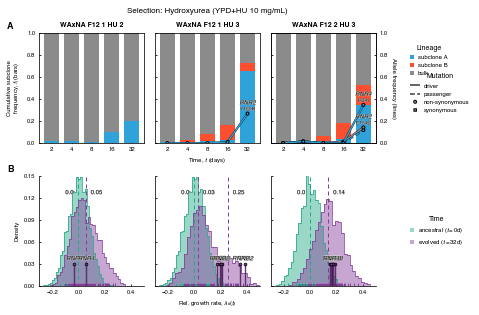

('RM', u'WAxNA_F12_1_RM_3', u'ancestral')
[-206.80324105953684, -211.82110430248329, -205.25484454861623]
Mean: 0.006682, Variance: 0.004395
Mean: 0.295974, Variance: 0.000290
('RM', u'WAxNA_F12_1_RM_3', u'evolved')
[143.66527693589273, 87.284098812658186, 86.31216015433526]
Mean: 0.969834, Variance: 0.018774
Mean: 1.363481, Variance: 0.005851
Mean: 0.087430, Variance: 0.016931
('RM', u'WAxNA_F12_1_RM_4', u'ancestral')
[-206.80324105953684, -211.82110430248329, -205.25484454861623]
Mean: 0.295974, Variance: 0.000290
Mean: 0.006682, Variance: 0.004395
('RM', u'WAxNA_F12_1_RM_4', u'evolved')
[104.93036222867757, 31.444643123539485, 33.778211560167328]
Mean: 0.878288, Variance: 0.016522
Mean: 0.122248, Variance: 0.016378
('RM', u'WAxNA_F12_2_RM_2', u'ancestral')
[-234.32468248365427, -219.98715046624565, -222.66055750224211]
Mean: 0.000176, Variance: 0.004637
('RM', u'WAxNA_F12_2_RM_2', u'evolved')
[65.971647630509167, -61.248773611046211, -58.14314643222103]
Mean: 0.071637, Variance: 0.0

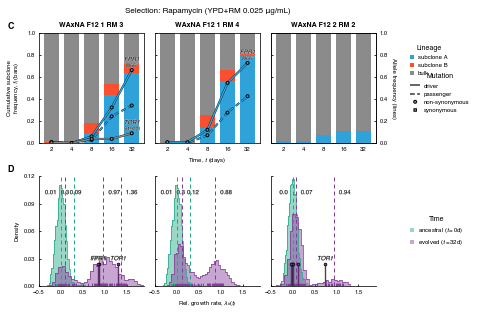

In [28]:
param = 'rel_growth_rate'

panels = {
    'HU': {
        'WAxNA_F12_1_HU_2':0,
        'WAxNA_F12_1_HU_3':1,
        'WAxNA_F12_2_HU_3':2
    },
    'RM': {
        'WAxNA_F12_1_RM_3':0,
        'WAxNA_F12_1_RM_4':1,
        'WAxNA_F12_2_RM_2':2
    }
}

populations = panels['HU'].keys()+panels['RM'].keys()
groups_st = seq_st_df[seq_st_df.population.isin(populations)]
groups_dn = seq_dn_df[(seq_dn_df.population.isin(populations))& \
                      (seq_dn_df.clone=='')& \
                      (seq_dn_df.gene!='non-coding')]
groups_ph = pheno_df[pheno_df.population.isin(populations)& \
                     np.isfinite(pheno_df[param])] # Take rows where param is finite
        
groups_st = groups_st.groupby('selection')
groups_dn = groups_dn.groupby('selection')
groups_ph = groups_ph.groupby(['selection','environment'])

for (ii, environment) in enumerate(['HU','RM']):
    
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(6, 4), sharey='row')
    
    fig.subplots_adjust(left=0.07,bottom=0.07,right=0.85,top=0.95,hspace=0.3,wspace=0.1)
    
    # Set scales
    for ax in axes[0]:
        ax.set_xlim(0, 32)
        ax.set_ylim(0, 1)
    for ax in axes[1]:
        if environment=='HU':
            ax.set_xlim(-0.3, 0.5)
            ax.set_ylim(0, 0.15)
        elif environment=='RM':
            ax.set_xlim(-0.5, 1.9)
            ax.set_ylim(0, 0.12)

    ### Top panels ###
    # De novo mutations #
    for (jj, (population, gdn)) in enumerate(groups_dn.get_group(environment).groupby('population')):
        
        # Retrieve axes
        ax1 = axes[0][panels[environment][population]]
        
        for (gene, cds_pos, sub, protein_pos, amino_acids, consequence), gdx in \
    gdn.groupby(['gene','cds_position','substitution','protein_position','amino_acids','consequence_short']):
        
            assignment = gdx.assignment.unique()[0]
            mutation_type = gdx.mutation_type.unique()[0]
            
            gdx.time = gdx.time.apply(int)
            gdx = gdx.sort_values('time').reset_index(drop=True)
            gdx = gdx.sort_index()
            
            ax1.plot(
                gdx.index.values, gdx.frequency.values,
                color=config.lineages[assignment]['fill'], 
                **utils.merge_two_dicts(config.mutation_type[mutation_type],
                                        config.consequence_short[consequence])
            )
            
            if mutation_type=='driver':
                index = np.argmax(gdx.frequency)
                ax1.annotate(gene, xy=(index,gdx.frequency[index]), style='italic', fontsize=6,
                             textcoords='offset points', xytext=(0, 13), ha = 'center', va = 'top',
                             path_effects=[path_effects.withStroke(linewidth=0.5, foreground="w")], zorder=3)
                ax1.annotate(amino_acids.split('/')[0]+protein_pos+amino_acids.split('/')[1], 
                             xy=(index,gdx.frequency[index]), fontsize=5,
                             textcoords='offset points', xytext=(0, 7), ha = 'center', va = 'top',
                             path_effects=[path_effects.withStroke(linewidth=0.4, foreground="w")], zorder=3)
    
    # Subclonal frequency #
    for (jj, (population,gst)) in enumerate(groups_st.get_group(environment).groupby('population')):

        # Retrieve axes
        ax2 = axes[0][panels[environment][population]]

        # Set title
        ax2.set_title(population.replace('_',' '), fontsize=7, weight='bold')
        # 
        gst.set_index('time', inplace=True)
        colors=[config.lineages[x]['fill'] for x in ['subclone A','subclone B','bulk']]
        gst[['subclone A','subclone B','bulk']].plot(
            ax=ax2, kind='bar', legend=False, 
            stacked=True, rot=0, width=0.75, position=0.5, color=colors
        )
        
        # Rotate the x-axis ticks
        ax2.set_xlabel('', rotation=0)

    ### Bottom panels ###
    for (jj, (population, gph)) in enumerate(groups_ph.get_group((environment,environment)).groupby('population')):

        # Retrieve axes
        ax3 = axes[1][panels[environment][population]]
        utils.simple_axes(ax3)
                                    
        for (kk, (time, gt)) in enumerate(gph.groupby('group')):
            
            print(environment, population, time)
            
            x, y = plot.histogram_binned_data(ax, gt[param], bins=34)

            ax3.plot(x, y, color=config.population['color'][time], linewidth=0.75)
            
            ax3.fill_between(x, 0, y, label=config.population['long_label'][time], 
                             alpha=0.45, facecolor=config.population['color'][time])
            
            # Mean of all isolates
            gt_all = gt.groupby(['isolate','gene','genotype_long','assignment'])
            gt_all = gt_all[param].agg(np.mean)#.mean()
            # Mean of random isolates
            gt_random = gt[(gt['assignment']=='')].groupby(['isolate','gene','genotype_long','assignment'])
            gt_random = gt_random[param].agg(np.mean)#.mean()
            # Mean of targeted isolates
            gt_target = gt[(gt['assignment']!='')].groupby(['isolate','gene','genotype_long','assignment'])
            gt_target = gt_target[param].agg(np.mean)#.mean()
            
            # Gaussian mixture model
            X = gt_random[:, np.newaxis]
            N = np.arange(1, 4)
                        
            models = gmm.gmm_fit(X, N)
            
            # Compute the AIC and the BIC
            AIC = [m.aic(X) for m in models]
            BIC = [m.bic(X) for m in models]
            M_best = models[np.argmin(BIC)]
            print BIC
            # Mean of the distribution
            for m, v in zip(abs(M_best.means_.ravel()), M_best.covariances_.ravel()):
                print('Mean: %.6f, Variance: %.6f' % (m, v,))
                ax3.plot([m,m], ax3.get_ylim(), 
                         color=config.population['color'][time], 
                         linestyle='--', dashes=(4,3), linewidth=1)
                pos = ax3.get_ylim()[0] * 0.75 + ax3.get_ylim()[1] * 0.25
                trans = ax3.get_xaxis_transform() # x in data units, y in axes fraction                    
                ax3.annotate(
                    np.around(m, 2), xy=(m, 0.85), xycoords=trans, fontsize=6,
                    color='k', va='center', ha=('right' if time=='ancestral' else 'left'),
                    xytext=((-5 if time=='ancestral' else 5),0), textcoords='offset points',
                    path_effects=[path_effects.withStroke(linewidth=0.5, foreground="w")]
                )
                        
            x_data = np.array(gt_all)
            y_data = np.repeat([0.03*(ax3.get_ylim()[1]-ax3.get_ylim()[0])], len(x_data))
            
            markerline, stemlines, baseline = ax3.stem(x_data, y_data)
                            
            plt.setp(markerline, 'markerfacecolor', config.population['color'][time], markersize = 0)
            plt.setp(stemlines, linewidth=1, color=config.population['color'][time], 
                     path_effects=[path_effects.withStroke(linewidth=0.75, foreground="w")])
            plt.setp(baseline, 'color', 'none')
            
            if len(gt_target)>0:
            
                x_data = np.array(gt_target)
                y_data = np.repeat([0.2*(ax3.get_ylim()[1]-ax3.get_ylim()[0])], len(x_data))
                
                markerline, stemlines, baseline = ax3.stem(x_data, y_data)
                
                plt.setp(markerline, 'color', config.population['color'][time], 
                         markersize = 2.75, markeredgewidth=.75, markeredgecolor='k', zorder=3)
                plt.setp(stemlines, linewidth=.75, color=config.population['color'][time],
                         path_effects=[path_effects.withStroke(linewidth=1.25, foreground='k')], zorder=2)  
                plt.setp(baseline, 'color', 'none', zorder=1)
                    
                for (isolate, gene, genotype, assignment), mean in gt_target.iteritems():
                    ax3.annotate(
                        gene, xy = (mean, 0.2), xycoords=('data','axes fraction'), 
                        xytext = (0, 8), textcoords = 'offset points', 
                        ha = 'center', va = 'top', fontsize = 6, style = 'italic',
                        path_effects=[path_effects.withStroke(linewidth=0.5, foreground="w")]
                    )
    
    # Set axes labels
    axes[0, 1].set_xlabel(r'Time, $t$ (days)')
    axes[0, 0].set_ylabel('Cumulative subclone\n frequency, $f_j$ (bars)')
    axes[0, 2].twinx().set_ylabel('Allele frequency (lines)', rotation=270, va='baseline')
    axes[1, 1].set_xlabel(r'Rel. growth rate, $\lambda_{k}(t)$')
    axes[1, 0].set_ylabel('Density')

    # Set legends
    leg1 = axes[0, 2].legend(bbox_to_anchor=(1.3, 0.75), frameon=False,
                             loc='center left', borderaxespad=0.,
                             handlelength=0.75, title='Lineage', prop={'size':6})
    
    driver_artist = lines.Line2D((0,1),(0,0), color=config.lineages['bulk']['fill'], 
                                 **config.mutation_type['driver'])
    passenger_artist = lines.Line2D((0,1),(0,0), color=config.lineages['bulk']['fill'], 
                                    **config.mutation_type['passenger'])
    nonsyn_artist = lines.Line2D((0,1),(0,0), mfc=config.lineages['bulk']['fill'],
                                 linestyle='', linewidth=1.5,
                                 path_effects=[path_effects.withStroke(linewidth=2, foreground="k")],
                                 **config.consequence_short['non-synonymous'])
    syn_artist = lines.Line2D((0,1),(0,0), mfc=config.lineages['bulk']['fill'],
                              linestyle='', linewidth=1.5,
                              path_effects=[path_effects.withStroke(linewidth=2, foreground="k")], 
                              **config.consequence_short['synonymous'])
    leg2 = axes[0, 2].legend([driver_artist,passenger_artist,nonsyn_artist,syn_artist], 
                             ['driver','passenger','non-synonymous','synonymous'], 
                             bbox_to_anchor=(1.3, 0.25), ncol=1,
                             frameon=False, loc='lower left',
                             borderaxespad=0, handlelength=1.75, 
                             title='Mutation', prop={'size':6})
    axes[0, 2].add_artist(leg1)
    
    axes[0, 2].get_legend().get_title().set_fontsize('7')
    
    leg3 = axes[1, 2].legend(bbox_to_anchor=(1.3, 0.5), frameon=False, 
                             loc='center left', borderaxespad=0., framealpha=1,
                             handlelength=0.75, title='Time', prop={'size':6})
    
    axes[1, 2].get_legend().get_title().set_fontsize('7')
    
    for leg in [leg1,leg2]:
        plt.setp(leg.get_title(), fontsize=7)
    
    # Set panel labels
    axes[0,0].text(-0.24, 1.1,  chr(2*ii + ord('A')), transform=axes[0,0].transAxes,
                   fontsize=9, fontweight='bold', va='top', ha='right')
    axes[0,1].text(0.5, 1.2, 'Selection: %s' % config.selection['long_label'][environment], 
                   transform=axes[0,1].transAxes, fontsize=8, va='center', ha='center')
    axes[1,0].text(-0.24, 1.1,  chr(2*ii + ord('B')), transform=axes[1,0].transAxes,
                   fontsize=9, fontweight='bold', va='top', ha='right')

    # Axes limits
    for ax in fig.get_axes():
        
        ax.xaxis.label.set_size(6)
        ax.yaxis.label.set_size(6)
        ax.tick_params(axis='both', which='major', size=2, labelsize=6)
        ax.tick_params(axis='both', which='minor', size=0, labelsize=0)
        
        plt.setp(ax.get_xticklabels(), fontsize=6)
        plt.setp(ax.get_yticklabels(), fontsize=6)
        
        for loc in ['top','bottom','left','right']:
            ax.spines[loc].set_linewidth(0.75)
        
        if ax.is_last_row():
            if environment=='HU':
                ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
                ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
            elif environment=='RM':
                ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
                ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=4))
    
    plot.save_figure(dir_paper+'figures/figure3/figure3_%s' % environment)
    plt.show()

**Fig. 3:** Reconstruction of subclonal dynamics. (**A** and **C**), Competing subclones evolved in (*A*) hydroxyurea and (*C*) rapamycin experienced a variety of fates. Time is on the $x$-axis, starting after crossing when the population has no competing subclones. Cumulative haplotype frequency of subclones (bars) and allele frequency of *de novo* mutants (lines) are on the $y$-axis. Most commonly, selective sweeps were observed where a spontaneous mutation arose and increased in frequency. Driver mutations are solid lines and passenger mutations are dashed lines, colored by subclone assignment; circles and squares denote non-synonymous and synonymous mutations, respectively. (**B** and **D**) Variability in intra-population growth rate , estimated by random sampling of 96 individuals at initial ($t = 0$ days, blue) and final ($t = 32$ days, red) time points ($n = 32$ technical replicates per individual). Mean growth rates by individual are shown at the foot of the histogram (Fig. S7). The posterior means of the distribution modes fitted by a Gaussian mixture model are indicated as dashed lines. The fitter individuals (pins) carry driver mutations, measured by targeted sampling and sequencing.

## Figure S3 - Sequence evolution of WAxNA founders

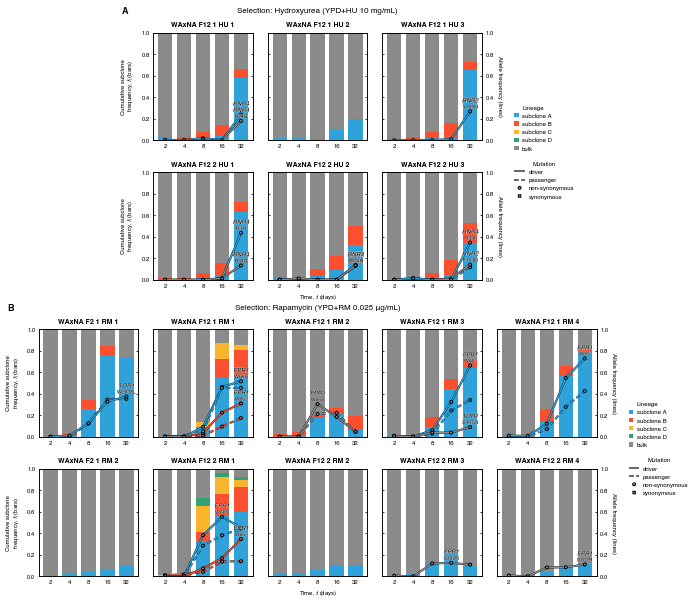

In [29]:
panels = {
    'HU': {
        'WAxNA_F12_1_HU_1':(0,1), 
        'WAxNA_F12_1_HU_2':(0,2), 
        'WAxNA_F12_1_HU_3':(0,3), 
        'WAxNA_F12_2_HU_1':(1,1), 
        'WAxNA_F12_2_HU_2':(1,2), 
        'WAxNA_F12_2_HU_3':(1,3)
    },
    'RM': {
        'WAxNA_F2_1_RM_1':(0,0),
        'WAxNA_F12_1_RM_1':(0,1), 
        'WAxNA_F12_1_RM_2':(0,2), 
        'WAxNA_F12_1_RM_3':(0,3), 
        'WAxNA_F12_1_RM_4':(0,4),
        'WAxNA_F2_1_RM_2':(1,0),
        'WAxNA_F12_2_RM_1':(1,1), 
        'WAxNA_F12_2_RM_2':(1,2), 
        'WAxNA_F12_2_RM_3':(1,3), 
        'WAxNA_F12_2_RM_4':(1,4)
    }
}

populations = panels['HU'].keys()+panels['RM'].keys()
groups_st = seq_st_df[seq_st_df.population.isin(populations)].groupby(['selection','population'])
groups_dn = seq_dn_df[(seq_dn_df.population.isin(populations))&\
                      (seq_dn_df.clone=='')&\
                      (seq_dn_df.gene!='non-coding')].groupby(['selection','population'])

# Create a figure with subplots
fig = plt.figure(figsize=(10, 10))

grid = gridspec.GridSpec(2, 1)

gs = {}

for (ii, e) in enumerate(['HU','RM']):
    
    nrows = 2
    ncols = 5
    gs[e] = gridspec.GridSpecFromSubplotSpec(nrows, ncols,
                                             subplot_spec=grid[ii],
                                             hspace=0.3, wspace=0.15)
    
    for (jj, p) in enumerate(panels[e]):
        
        # Retrieve axes
        ax1 = plt.subplot(gs[e][panels[e][p]])
        ax2 = ax1.twinx()
                    
        ### Subclone frequency ###
        gst = groups_st.get_group((e,p))
        
        # Set title
        ax1.set_title(p.replace('_',' '), fontsize=7, weight='bold')

        # Bar plot
        gst = gst.set_index('time')
        gst = gst[['subclone A','subclone B','subclone C','subclone D','bulk']]
        gst.plot(ax=ax1, kind='bar',
                 legend=False, stacked=True, width=0.75, position=0.5,
                 color=[config.lineages[c]['fill'] for c in gst.columns])
        
        ### De novo mutations ###
        if (e,p) in groups_dn.groups.keys():

            gdn = groups_dn.get_group((e,p))
            
            for (gene, pos, cds, sub, protein_pos, amino_acids, consequence), gdx \
            in gdn.groupby(['gene','pos','cds_position','substitution',\
                            'protein_position','amino_acids','consequence_short']):
                
                assignment = gdx.assignment.unique()[0]
                mutation_type = gdx.mutation_type.unique()[0]
            
                gdx = gdx.sort_values('time').reset_index(drop=True)
                gdx = gdx.sort_index()

                ax2.plot(gdx.index.values, gdx.frequency.values,
                         color=config.lineages[assignment]['line'],
                         **utils.merge_two_dicts(config.mutation_type[mutation_type],
                                                 config.consequence_short[consequence]))

                if mutation_type=='driver':
                    index = np.argmax(gdx.frequency)
                    ax2.annotate(
                        gene, xy=(index,gdx.frequency[index]), style='italic', fontsize=6,
                        textcoords='offset points', xytext=(0, 13), ha = 'center', va = 'top',
                        path_effects=[path_effects.withStroke(linewidth=0.5, foreground="w")], zorder=3
                    )
                    ax2.annotate(
                        amino_acids.split('/')[0]+protein_pos+amino_acids.split('/')[1], 
                        xy=(index,gdx.frequency[index]), fontsize=5,
                        textcoords='offset points', xytext=(0, 7), ha = 'center', va = 'top',
                        path_effects=[path_effects.withStroke(linewidth=0.4, foreground="w")], zorder=3
                    )
        
        # Set legends
        if (e,p) in [('HU','WAxNA_F12_1_HU_3'),('RM','WAxNA_F12_1_RM_4')]:
            
            leg1 = ax1.legend(bbox_to_anchor=(1.3, -0.125), ncol=1,
                              frameon=False, loc='lower left', 
                              borderaxespad=0., handlelength=0.7, 
                              title='Lineage', prop={'size':6})
    
        if (e,p) in [('HU','WAxNA_F12_2_HU_3'),('RM','WAxNA_F12_2_RM_4')]:
            
            driver_artist = lines.Line2D((0,1),(0,0), color=config.lineages['bulk']['fill'], 
                                         **config.mutation_type['driver'])
            passenger_artist = lines.Line2D((0,1),(0,0), color=config.lineages['bulk']['fill'], 
                                            **config.mutation_type['passenger'])
            nonsyn_artist = lines.Line2D((0,1),(0,0), mfc=config.lineages['bulk']['fill'], linestyle='',
                                         path_effects=[path_effects.withStroke(linewidth=2, foreground="k")],
                                         **config.consequence_short['non-synonymous'])
            syn_artist = lines.Line2D((0,1),(0,0), mfc=config.lineages['bulk']['fill'], linestyle='', 
                                      path_effects=[path_effects.withStroke(linewidth=2, foreground="k")],
                                      **config.consequence_short['synonymous'])
            leg2 = ax1.legend([driver_artist,passenger_artist,nonsyn_artist,syn_artist], 
                              ['driver','passenger','non-synonymous','synonymous'], 
                              bbox_to_anchor=(1.3, 1.125), ncol=1,
                              frameon=False, loc='upper left',
                              borderaxespad=0, handlelength=1.75, 
                              title='Mutation', prop={'size':6})
            
        for leg in [leg1,leg2]:
            plt.setp(leg.get_title(),fontsize=6)

        # Set axes labels
        if (e,p) in [('HU','WAxNA_F12_2_HU_2'),('RM','WAxNA_F12_2_RM_2')]:
            ax1.set_xlabel(r'Time, $t$ (days)')
        else:
            ax1.set_xlabel('')
        if (e,p) in [('HU','WAxNA_F12_1_HU_1'),('RM','WAxNA_F2_1_RM_1'),
                     ('HU','WAxNA_F12_2_HU_1'),('RM','WAxNA_F2_1_RM_2')]:
            ax1.set_ylabel('Cumulative subclone\n frequency, $f_j$ (bars)')
        else:
            ax1.set_yticklabels([])
        if (e,p) in [('HU','WAxNA_F12_1_HU_3'),('RM','WAxNA_F12_1_RM_4'),
                     ('HU','WAxNA_F12_2_HU_3'),('RM','WAxNA_F12_2_RM_4')]:
            ax2.set_ylabel('Allele frequency (lines)', rotation=270, va='baseline')
        else:
            ax2.set_yticklabels([])
        
        plt.setp(ax1.xaxis.get_majorticklabels(), rotation=0) # rotate the x-axis ticks

        # Set panel labels
        if (e,p) in [('HU','WAxNA_F12_1_HU_1'),('RM','WAxNA_F2_1_RM_1')]:
            ax1.text(-0.25, 1.2,  chr(ii + ord('A')), transform=ax1.transAxes,
                     fontsize=9, fontweight='bold', va='center', ha='right')
        if (e,p) in [('HU','WAxNA_F12_1_HU_2'),('RM','WAxNA_F12_1_RM_2')]:
            ax1.text(0.5, 1.2, 'Selection: %s' % config.selection['long_label'][e],
                     transform=ax1.transAxes, fontsize=8, va='center', ha='center')

for ax in fig.get_axes():
            
    ax.set_ylim(0, 1) # axes limits
    
    ax.xaxis.label.set_size(6)
    ax.yaxis.label.set_size(6)
    ax.tick_params(axis='both', which='major', size=2, labelsize=6)
    ax.tick_params(axis='both', which='minor', size=0, labelsize=0)
            
    plt.setp(ax.get_xticklabels(), fontsize=6)
    plt.setp(ax.get_yticklabels(), fontsize=6)

    for tick in ax.get_xticklabels():
        tick.set_visible(True)
        
    for loc in ['top','bottom','left','right']:
        ax.spines[loc].set_linewidth(.75)

plot.save_figure(dir_supp+'figures/supp_figure_seq_subclonal_dynamics/supp_figure_seq_subclonal_dynamics_cross')
plt.show()

**Fig. S3:** Subclonal dynamics in time for WAxNA founders evolved in (**A**) hydroxyurea and (**B**) rapamycin, measured by whole-population sequencing. Time is on the $x$-axis, starting after crossing when the population has no competing subclones. Cumulative haplotype frequency of subclones (bars) and allele frequency of *de novo* mutants (lines) are on the $y$-axis. Driver mutations are solid lines and passenger mutations are dashed lines, colored by subclone assignment; circles and squares denote non-synonymous and synonymous mutations, respectively. No macroscopic subclones or *de novo* mutations were detected in any of the control replicates in YPD.

## Figure S4 - Sequence evolution of WA, NA founders

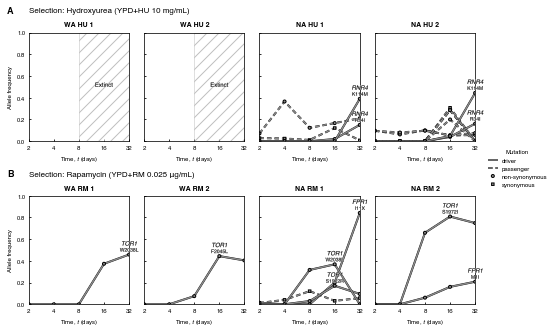

In [30]:
panels = {
    'HU': {
        'WA_HU_1':(0,0),
        'WA_HU_2':(0,1),
        'NA_HU_1':(0,2),
        'NA_HU_2':(0,3),
    },
    'RM': {
        'WA_RM_1':(0,0),
        'WA_RM_2':(0,1),
        'NA_RM_1':(0,2),
        'NA_RM_2':(0,3),
    }
}

populations = panels['HU'].keys()+panels['RM'].keys()
groups_dn = seq_dn_df[(seq_dn_df.population.isin(populations)) & \
                      (seq_dn_df.clone=='') & \
                      (seq_dn_df.gene!='non-coding')].groupby(['selection','population'])

# Get a figure with a lot of subplots
fig = plt.figure(figsize=(8, 5))

grid = gridspec.GridSpec(2, 1, hspace=0.5)

gs = {}

for (ii, e) in enumerate(['HU','RM']):
    
    nrows = 1
    ncols = 4
    gs[e] = gridspec.GridSpecFromSubplotSpec(nrows, ncols,
                                             subplot_spec=grid[ii],
                                             wspace=0.15)

    ### De novo mutations ###
    for (jj, p) in enumerate(panels[e].keys()):
        
        # Retrieve axes
        ax = plt.subplot(gs[e][panels[e][p]])
        
        # Set title
        ax.set_title(p.replace('_',' '), fontsize=7, weight='bold')
    
        # Set axes labels
        if (e,p) in [('HU','WA_HU_1'),('RM','WA_RM_1')]:
            ax.set_ylabel('Allele frequency')
            ax.text(-0.15, 1.2, chr(ii + ord('A')), transform=ax.transAxes,
                    fontsize=9, fontweight='bold', va='center', ha='right')
            ax.text(0., 1.2, 'Selection: %s' % config.selection['long_label'][e], 
                    transform=ax.transAxes, fontsize=8, va='center', ha='left')
            ax.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0])
        else:
            ax.set_yticklabels([])

        ax.set_xlabel(r'Time, $t$ (days)')
        
        # Set legend
        if (e,p) in [('HU','NA_HU_2')]:
            driver_artist = lines.Line2D((0,1),(0,0), color=config.lineages['bulk']['fill'], 
                                         **config.mutation_type['driver'])
            passenger_artist = lines.Line2D((0,1),(0,0), color=config.lineages['bulk']['fill'], 
                                            **config.mutation_type['passenger'])
            nonsyn_artist = lines.Line2D((0,1),(0,0), mfc=config.lineages['bulk']['fill'], linestyle='',
                                         path_effects=[path_effects.withStroke(linewidth=2, foreground="k")],
                                         **config.consequence_short['non-synonymous'])
            syn_artist = lines.Line2D((0,1),(0,0), mfc=config.lineages['bulk']['fill'], linestyle='', 
                                      path_effects=[path_effects.withStroke(linewidth=2, foreground="k")],
                                      **config.consequence_short['synonymous'])
            leg1 = ax.legend([driver_artist,passenger_artist,nonsyn_artist,syn_artist], 
                             ['driver','passenger','non-synonymous','synonymous'], 
                             bbox_to_anchor=(1.1, -0.25), ncol=1,
                             frameon=False, loc='center left',
                             borderaxespad=0, handlelength=1.75, 
                             title='Mutation', prop={'size':6})
            plt.setp(leg1.get_title(),fontsize=6)
        
        # Set empty panels
        if (e,p) in groups_dn.groups.keys():
            gdn = groups_dn.get_group((e,p))
        else:
            ax.axvspan(8, 32, facecolor='w', edgecolor='0.5', alpha=0.5, hatch='//')
            ax.annotate('Extinct', xy=(16,0.5), fontsize=6, ha='center',
                        path_effects=[path_effects.withStroke(linewidth=0.5, foreground="w")])
            continue

        for (gene, cds_pos, sub, protein_pos, amino_acids, consequence), gdx in \
    gdn.groupby(['gene','cds_position','substitution','protein_position','amino_acids','consequence_short']):
        
            assignment = gdx.assignment.unique()[0]
            mutation_type = gdx.mutation_type.unique()[0]

            gdx.time = gdx.time.apply(int)
            gdx = gdx.sort_values('time').reset_index(drop=True)
            gdx = gdx.sort_index()
            gdx = gdx.set_index('time')
            
            ax.plot(gdx.index, gdx.frequency,
                    color=config.lineages['bulk']['line'], 
                    **utils.merge_two_dicts(config.mutation_type[mutation_type],
                                            config.consequence_short[consequence]))
            
            if mutation_type=='driver':
                index = np.argmax(gdx.frequency)
                ax.annotate(
                    gene, xy=(index,gdx.frequency[index]), style='italic', fontsize=6,
                    textcoords='offset points', xytext=(0, 13), ha = 'center', va = 'top',
                    path_effects=[path_effects.withStroke(linewidth=0.5, foreground="w")], zorder=3
                )
                ax.annotate(
                    amino_acids.split('/')[0]+protein_pos+amino_acids.split('/')[1], 
                    xy=(index,gdx.frequency[index]), fontsize=5,
                    textcoords='offset points', xytext=(0, 7), ha = 'center', va = 'top',
                    path_effects=[path_effects.withStroke(linewidth=0.4, foreground="w")], zorder=3
                )

for ax in fig.get_axes():
    
    ax.set_xlim(2, 32) # axes limits
    ax.set_ylim(0, 1)
    
    ax.xaxis.label.set_size(6)
    ax.yaxis.label.set_size(6)
    ax.tick_params(axis='both', which='major', size=2, labelsize=6)
    ax.tick_params(axis='both', which='minor', size=0, labelsize=0)
    
    plt.setp(ax.get_xticklabels(), fontsize=6)
    plt.setp(ax.get_yticklabels(), fontsize=6)
    
    ax.set_xscale('log', base=2)
    ax.set_xticks([2, 4, 8, 16, 32])
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
    
    for loc in ['top','bottom','left','right']:
        ax.spines[loc].set_linewidth(0.75)

plot.save_figure(dir_supp+'figures/supp_figure_seq_subclonal_dynamics/supp_figure_seq_subclonal_dynamics_parents')
plt.show()

**Fig. S4:** Subclonal dynamics in time for WA and NA founders evolved in (**A**) hydroxyurea and (**B**) rapamycin, measured by whole-population sequencing. WA founders evolved in hydroxyurea did not survive after 4 days. Driver mutations are solid lines and passenger mutations are dashed lines, colored by subclone assignment; circles and squares denote non-synonymous and synonymous mutations, respectively. No *de novo* mutations were detected in any of the control replicates in YPD.

## Figure S9 - Phenotype evolution

We are inferring the model's components ($F, \lambda_1, \sigma_{\lambda_1}, \lambda_2, \sigma_{\lambda_2}$) using a Gaussian mixture model.

(u'HU', u'WAxNA_F12_1_HU_2')
Empty DataFrame
Columns: [(HU, mean), (RM, mean), (SC, mean)]
Index: []
                                             HU   RM        SC
                                           mean mean      mean
isolate gene genotype_long assignment                         
1       RNR4 RNR4*/RNR4*   bulk       -0.031631  NaN -0.050832
2       RNR4 RNR4*/RNR4*   bulk        0.058815  NaN -0.094872
(u'HU', u'WAxNA_F12_1_HU_3')
Empty DataFrame
Columns: [(HU, mean), (RM, mean), (SC, mean)]
Index: []
                                             HU   RM        SC
                                           mean mean      mean
isolate gene genotype_long assignment                         
1       RNR2 RNR2*/RNR2    subclone A  0.176067  NaN -0.030428
2       RNR2 RNR2*/RNR2    subclone A  0.209420  NaN -0.037551
3       RNR2 RNR2*/RNR2    subclone A  0.192393  NaN -0.056146
4       RNR2 RNR2*/RNR2    subclone A  0.203274  NaN -0.046559
5       RNR2 RNR2*/RNR2    subclone A  0.3

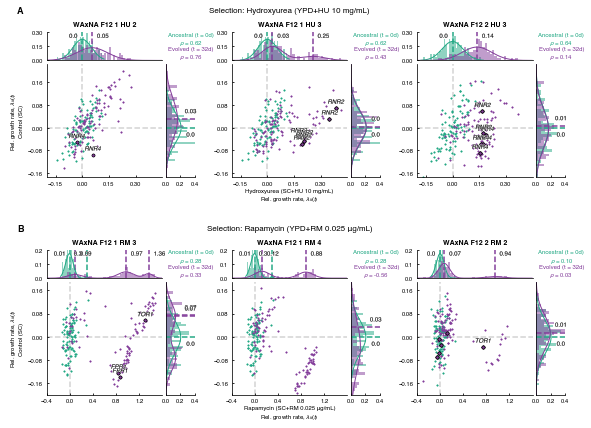

In [18]:
param='rel_growth_rate'

scatter_panels = {
    'WAxNA_F12_1_HU_2':0,
    'WAxNA_F12_1_HU_3':1,
    'WAxNA_F12_2_HU_3':2,
    'WAxNA_F12_1_RM_3':3,
    'WAxNA_F12_1_RM_4':4,
    'WAxNA_F12_2_RM_2':5,
}

data = pheno_df[pheno_df.population.isin(scatter_panels.keys())& \
                np.isfinite(pheno_df[param])] # Take rows where param is finite
data = pd.pivot_table(
    data, 
    index=['selection','population','group','isolate','gene','genotype_long','assignment'], 
    columns='environment', 
    values=param,
    aggfunc=np.mean
)

corr = pheno_df[pheno_df.population.isin(scatter_panels.keys())& \
                np.isfinite(pheno_df[param])] # Take rows where param is finite
corr = pd.pivot_table(
    corr, 
    index=['isolate','gene','genotype_long','assignment'], 
    columns=['selection','population','group','environment'], 
    values=param,
    aggfunc=np.mean
)
corr = corr.groupby(level=['selection','population','group'], axis=1, group_keys=False)
corr = corr.apply(lambda x: x.corr(method='spearman'))
corr = corr.query('environment==\'SC\'')
corr = pd.melt(corr).dropna()
corr = corr.pivot_table(columns=['group'], index=['selection','population','environment'], values='value')
    
fig = plt.figure(figsize=(7.5,5.25))
fig.subplots_adjust(left=0.02, right=0.98, bottom=0.02, top=0.98)

# Make outer gridspec
grid = gridspec.GridSpec(nrows=2, ncols=3, width_ratios=[2, 2, 2], hspace=.5, wspace=.25) 

gs = {}

for ii, ((s, p), gp) in enumerate(data.groupby(level=['selection','population'])):
    print(s, p)
    # Use gridspec to assign different formats to panels in one plot
    gs[(s,p)] = gridspec.GridSpecFromSubplotSpec(nrows=2, ncols=2, hspace=.05, wspace=.05, 
                                                 width_ratios=[4,1], height_ratios=[1,4], 
                                                 subplot_spec=grid[scatter_panels[p]])
    
    ax = plt.subplot(gs[(s,p)][:])
    ax_scatter = plt.subplot(gs[(s,p)][1,0])
    ax_x = plt.subplot(gs[(s,p)][0,0])
    ax_y = plt.subplot(gs[(s,p)][1,1])

    # Define plot ranges at beginning, since used often later
    x = gp['SC'].values
    y = gp[s].values
    
    if s=='HU':
        x_range = [-0.2, 0.45]
        y_range = [-0.175, 0.225]
        x_count_range = [0, 0.4]
        y_count_range = [0, 0.3]
    elif s=='RM':
        x_range = [-0.4, 1.6]
        y_range = [-0.2, 0.19]
        x_count_range = [0, 0.4]
        y_count_range = [0, 0.2]

    # Set title
    ax_x.set_title(p.replace('_',' '), fontsize=7, weight='bold')
    
    ax_scatter.annotate(
        'Ancestral (t = 0d)\n' r'$\rho$ = {:.2f}'.format(corr.ix[s, p, s]['ancestral']),
        xy=(1.25, 1.15), xycoords='axes fraction', fontsize=6,
        color=config.population['color']['ancestral'], ha='center', va='bottom'
    )
    ax_scatter.annotate(
        'Evolved (t = 32d)\n' r'$\rho$ = {:.2f}'.format(corr.ix[s, p, s]['evolved']),
        xy=(1.25, 1.025), xycoords='axes fraction', fontsize=6,
        color=config.population['color']['evolved'], ha='center', va='bottom'
    )
    ax_scatter.axvline(x=0, ls='--', lw=1.5, color='lightgray', zorder=0)
    ax_scatter.axhline(y=0, ls='--', lw=1.5, color='lightgray', zorder=0)

    for jj, (t, gt) in enumerate(gp.groupby(level='group')):
        
        gt_all = gt.groupby(level=['isolate','gene','genotype_long','assignment']).agg([np.mean])
        gt_random = gt.query('assignment==\'\'').groupby(level=['isolate','gene','genotype_long','assignment']).agg([np.mean])
        gt_target = gt.query('assignment!=\'\'').groupby(level=['isolate','gene','genotype_long','assignment']).agg([np.mean])
        print gt_target
        x_a = gt_all[s]
        y_a = gt_all['SC']
        
        x_r = gt_random[s]
        y_r = gt_random['SC']
        color = config.population['color'][t]
        
        # Scatter plot
        plot.scatter_plot(x_r, y_r, ax=ax_scatter, marker='.', color=color, ms=3)
        ax_scatter.set_xlim(x_range)
        ax_scatter.set_ylim(y_range)

#         ax_scatter.annotate(corr.ix[s, p, 'SC'][t],
#                             xy=(0.95, 0.05), xycoords='axes fraction', fontsize=8,
#                             color=color, ha='right', va='bottom')
        
        for (isolate, gene, genotype, assignment), data in gt_target.iterrows():
            x_t = gt_target[s]
            y_t = gt_target['SC']
            plot.scatter_plot(x_t, y_t, ax=ax_scatter, marker='o', ms=3, mec='k', mfc=color)
            ax_scatter.annotate(
                gene, xy = (data[s], data['SC']), xycoords='data', 
                xytext = (0, 8), textcoords = 'offset points', 
                ha = 'center', va = 'top', 
                fontsize = 6, style = 'italic', 
                path_effects=[path_effects.withStroke(linewidth=0.5, foreground="w")]
            )
        
        # x-axis
        plot.histogram_x(x_r, ax=ax_x, time=t)
        ax_x.set_xlim(x_range)
        ax_x.set_ylim(y_count_range)
        
        # Mean of sequenced isolates       
#         lollipops(x_s, ax_x)
        
        # y-axis
        plot.histogram_y(y_r, ax=ax_y, time=t)
        ax_y.set_xlim(x_count_range)
        ax_y.set_ylim(y_range)

# Set axes labels
ax = plt.subplot(gs[('HU','WAxNA_F12_1_HU_3')][1,0])
ax.set_xlabel('%s\nRel. growth rate, $\lambda_k(t)$' % config.environment['long_label']['HU'])
ax = plt.subplot(gs[('HU','WAxNA_F12_1_HU_2')][1,0])
ax.set_ylabel('Rel. growth rate, $\lambda_k(t)$\n%s' % config.environment['long_label']['SC'])

ax = plt.subplot(gs[('RM','WAxNA_F12_1_RM_4')][1,0])
ax.set_xlabel('%s\nRel. growth rate, $\lambda_k(t)$' % config.environment['long_label']['RM'])
ax = plt.subplot(gs[('RM','WAxNA_F12_1_RM_3')][1,0])
ax.set_ylabel('Rel. growth rate, $\lambda_k(t)$\n%s' % config.environment['long_label']['SC'])

# Set panel labels
ax = plt.subplot(gs[('HU','WAxNA_F12_1_HU_2')][0,0])
ax.text(-.2, 1.75, chr(ord('A')), transform=ax.transAxes,
        fontsize=9, fontweight='bold', va='center', ha='right')
ax = plt.subplot(gs[('HU','WAxNA_F12_1_HU_3')][0,0])
ax.text(0.5, 1.75, 'Selection: %s' % config.selection['long_label']['HU'], transform=ax.transAxes,
        fontsize=8, va='center', ha='center')
ax = plt.subplot(gs[('RM','WAxNA_F12_1_RM_3')][0,0])
ax.text(-.2, 1.75, chr(ord('B')), transform=ax.transAxes,
        fontsize=9, fontweight='bold', va='center', ha='right')
ax = plt.subplot(gs[('RM','WAxNA_F12_1_RM_4')][0,0])
ax.text(0.5, 1.75, 'Selection: %s' % config.selection['long_label']['RM'], transform=ax.transAxes,
        fontsize=8, va='center', ha='center')
    
# Axes limits
for ax in fig.get_axes():
    ax.xaxis.label.set_size(6)
    ax.yaxis.label.set_size(6)
    ax.tick_params(axis='both', which='major', size=2, labelsize=6)
    ax.tick_params(axis='both', which='minor', size=0, labelsize=6)
    
    for loc in ['top','bottom','left','right']:
        ax.spines[loc].set_linewidth(0.75)

plot.save_figure(dir_supp+'figures/supp_figure_pheno_evolution/supp_figure_pheno_evolution')
plt.show()

**Fig. S9:** Variability in intra-population growth rate and fitness correlations. Fitness correlations of ancestral and evolved populations across environments, estimated by random sampling of individuals at initial (0 days, green) and final time points (32 days, purple), before and after selection in (**A**) hydroxyurea and (**B**) rapamycin. The relative growth rate $\lambda_k(t)$ per individual $k$ is shown, calculated by averaging over ${n_r\,{=}\,32}$ technical replicates per individual. Relative growth rates are normalized with respect to the mean population growth rate $\langle\lambda_k\rangle_{t=0}$ at $t=0$ days (see Figures 3B and 3D). The relative growth rates $\lambda_k(t)$ in the stress environment ($x$-axis) are compared to the control environment ($y$-axis). Using a Gaussian mixture model, we found the posterior probability of the mixture modes of the the best-fit mixture (solid lines). The posterior means of the distribution modes are indicated as dashed lines. The fitter individuals carry driver mutations, as determined by targeted sampling and sequencing. Spearman's rank correlation, $\rho$, is shown on the top right of each panel, to assess the association between the growth rate of isolates in the stress and control environments at 0 and 32 days.
